In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Import our RBM
from RBM import RBM

In [2]:
# Function for reading data file
import struct
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
X_test = read_idx("data/MNIST/raw/t10k-images-idx3-ubyte").reshape(-1, 28*28)
X = read_idx("data/MNIST/raw/train-images-idx3-ubyte").reshape(-1, 28*28)
y_test = read_idx("data/MNIST/raw/t10k-labels-idx1-ubyte")
y = read_idx("data/MNIST/raw/train-labels-idx1-ubyte")

# EXTREMELY IMPORTANT TO NORMALIZE
X = np.true_divide(X, 255)
X_test = np.true_divide(X_test, 255)

C:\Users\91881\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


In [4]:
# Some hand picked images for each class for plotting
selected_imgs = X[[1, 6, 5, 12, 26, 35, 62, 52, 46, 4]]

In [5]:
# Train-val split
split = 0.1
indices = np.arange(len(X))
np.random.shuffle(indices)
X_val = X[:int(split*X.shape[0])]
X_train = X[int(split*X.shape[0]):]
y_val = y[:int(split*X.shape[0])]
y_train = y[int(split*X.shape[0]):]
print("Number of training instances:\t", y_train.shape[0])
print("Number of validation instances:\t", y_val.shape[0])
print("Number of test instances:\t", y_test.shape[0])

Number of training instances:	 54000
Number of validation instances:	 6000
Number of test instances:	 10000


In [6]:
def get_batches(data, batch_size, shuffle=False):
    '''
    Function to provide data in batches.
    input:
        - data: The data to be batched, each sample in one row.
        - batch_size: Size of one batch (last batch might be smaller)
        - shuffle: True if data should be shuffled.
    '''
    if(shuffle):
        np.random.shuffle(data)
    if(batch_size == -1):
        batch_size = len(data)
    num_batches = math.ceil(data.shape[0]/batch_size)
    for batch_num in range(num_batches):
        yield data[batch_num*batch_size:(batch_num+1)*batch_size]

In [7]:
def plot_images(rbm, images, title='Reconstructed Images', save_as="Reconstructed Images"):
    '''
    Plot the images and their reconstruction from RBM.
    input:
        - rbm: The RBM object to be used.
        - images: The images to be reconstructed (batch, 28, 28)
    '''
    num_samples = len(images)
    plt.clf()
    fig, axes = plt.subplots(2, num_samples, gridspec_kw = {'wspace':0, 'hspace':0.1}, figsize=(2*num_samples, 4))
    fig.suptitle(title)
    text = axes[0, 0].text(-7, 14,"original", size=15,
                           verticalalignment='center', rotation=-270)
    text = axes[1, 0].text(-7, 13,"reconstructed", size=15,
                           verticalalignment='center', rotation=-270)
    for n in range(num_samples):
        axes[0, n].imshow(images[n].reshape(28, 28), cmap='gray')
        axes[1, n].imshow(rbm.reconstruct(images[n].reshape(28*28)).reshape(28, 28), cmap='gray')
        axes[0, n].axis('off')
        axes[1, n].axis('off')

    plt.savefig(save_as)
    plt.show()
    plt.close()

In [8]:
def plot_weights(rbm, title='weights', save_as="weights"):
    '''
    Plot the weight parameter of the RBM, one for each hidden unit.
    '''
    plt.clf()
    fig, axes = plt.subplots(10, 10, gridspec_kw = {'wspace':0.1, 'hspace':0.1}, figsize=(8, 8))
    fig.suptitle(title)
    for i in range(10):
        for j in range(10):
            axes[i, j].imshow(rbm.W[:,i*10+j].reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')

    plt.savefig(save_as)
    plt.show()
    plt.close()

In [9]:
# Some parameters to set
batch_size = 50
num_epochs = 20
lr = 0.1
burn_in = 0
num_steps = 1

In [10]:
# Our RBM object
rbm = RBM(n_vis=28*28, n_hid=100)

In [11]:
# Training loop
errors = []
free_energies_val = []
free_energies_train = []
start_time = time()

# plot_images(rbm, selected_imgs, 
#             title="Reconstructed Images    Epoch: 0",
#             save_as="recon_" + str(0))

for epoch in range(1, num_epochs+1):
    iteration = 0
    error = 0
    for batch in get_batches(X_train, batch_size, shuffle=True):
        iteration += 1
   
        # Compute gradients and errors
        error += rbm.compute_error_and_grads(batch, burn_in=burn_in, num_steps=num_steps)
        
        # Update parameters - use momentum as explained in Hinton's guide
        if(epoch > 5):
            rbm.update_params(lr, momentum=0.5)
        else:
            rbm.update_params(lr, momentum=0.9)
        
    #plot_images(rbm, selected_imgs, 
    #        title="Reconstructed Images    Epoch: {}".format(epoch),
    #        save_as="recon_" + str(epoch))
        
    print("epoch:{} \t error:{:.4f} \t training time:{:.2f} s".format(epoch, error, time()-start_time))
    errors.append(error)

epoch:1 	 error:28343.8269 	 training time:16.33 s
epoch:2 	 error:16556.4423 	 training time:32.03 s
epoch:3 	 error:15083.3649 	 training time:48.81 s
epoch:4 	 error:14303.8892 	 training time:65.40 s
epoch:5 	 error:13822.7107 	 training time:81.96 s
epoch:6 	 error:13511.2650 	 training time:99.20 s
epoch:7 	 error:13277.1605 	 training time:114.04 s
epoch:8 	 error:13078.5397 	 training time:130.05 s
epoch:9 	 error:12926.8900 	 training time:145.42 s
epoch:10 	 error:12805.7153 	 training time:161.24 s
epoch:11 	 error:12688.4119 	 training time:177.56 s
epoch:12 	 error:12578.4870 	 training time:193.35 s
epoch:13 	 error:12490.0239 	 training time:208.34 s
epoch:14 	 error:12405.1934 	 training time:224.93 s
epoch:15 	 error:12334.3157 	 training time:240.62 s
epoch:16 	 error:12252.3623 	 training time:255.44 s
epoch:17 	 error:12198.6438 	 training time:272.29 s
epoch:18 	 error:12149.1411 	 training time:288.44 s
epoch:19 	 error:12110.2196 	 training time:304.19 s
epoch:20

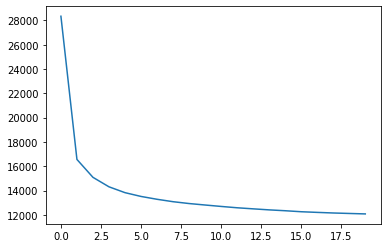

In [13]:
plt.plot(errors)
plt.savefig("error_plot")

<Figure size 432x288 with 0 Axes>

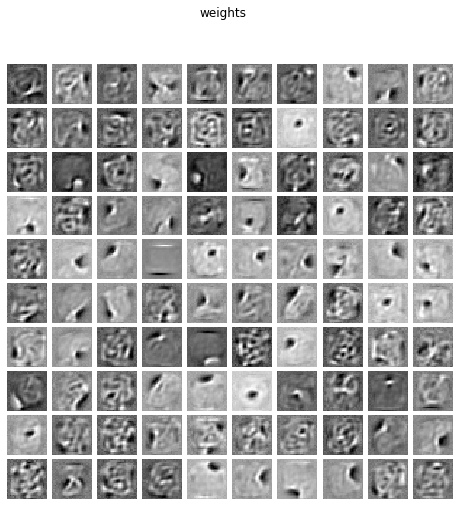

In [14]:
plot_weights(rbm)

<Figure size 432x288 with 0 Axes>

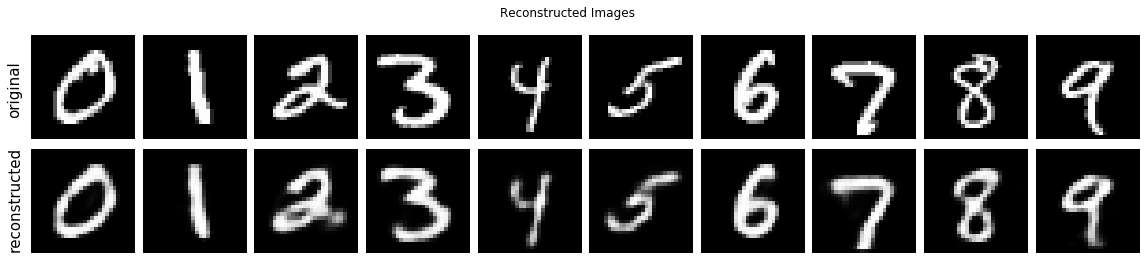

In [15]:
plot_images(rbm, selected_imgs)